In [2]:
from python_graphql_client import GraphqlClient
import pandas as pd
from datetime import datetime
import matplotlib

In [3]:
def client():
    return GraphqlClient(endpoint="https://api.studio.thegraph.com/query/19821/tornado-subgraph-mainnet/t00")

def query(event, skip, timestamp):
    return """
    {
      """+event+"""(first: 1000, orderBy: timestamp, skip: """+ str(skip)+""",
      where: {timestamp_gt: """+ str(timestamp) +"""}) {
        id
        """+ ('from' if event =='deposits' else '') +"""
        index
        amount
        currency
        timestamp
      }

    }
"""

In [4]:
def getPoolEvents(event, debug=False):
    timestamp=0
    poolEvents=0
    
    while(True):
        skip=0
        poolEventsTs=0
        while(skip <= 5000):
            querys = query(event, skip, timestamp)
            try:
                tgdata_raw = client().execute(query=querys)['data'][event]
                if debug : print(skip, timestamp, len(tgdata_raw))
            except:
                print(client().execute(query=querys))
                break
            tgdata = pd.DataFrame.from_dict(tgdata_raw)
            if type(poolEventsTs) is int : poolEventsTs = tgdata 
            else : poolEventsTs = pd.concat([poolEventsTs,tgdata], ignore_index=True)

            if tgdata.shape[0] < 1000: break
            skip = skip + 1000
        if type(poolEvents) is int :  poolEvents = poolEventsTs 
        else :  poolEvents = pd.concat([poolEvents,poolEventsTs], ignore_index=True)

        if poolEventsTs.shape[0] < 6000: break
        timestamp = str(int(poolEventsTs['timestamp'].iloc[-1]) -1)

    return poolEvents

depositDf = getPoolEvents('deposits')
withdrawalDf = getPoolEvents('withdrawals')

In [5]:
depositDf['index'] = depositDf['index'].astype(int)
withdrawalDf['index'] = withdrawalDf['index'].astype(int)
depositDf['type'] = 'D'
withdrawalDf['type'] = 'W'
poolEventsDf = pd.concat([withdrawalDf, depositDf[['id','index','amount','currency','timestamp','type']]])

date grouping

In [6]:
poolEventsDf

,id,index,amount,currency,timestamp,type
0,0x0246beddfc8841c52dde875d6487c41c7c28b2a6ae56...,138,0.1,eth,1576524070,W
1,0x0246beddfc8841c52dde875d6487c41c7c28b2a6ae56...,139,0.1,eth,1576524070,W
2,0x0246beddfc8841c52dde875d6487c41c7c28b2a6ae56...,140,0.1,eth,1576524070,W
3,0x0246beddfc8841c52dde875d6487c41c7c28b2a6ae56...,141,0.1,eth,1576524070,W
4,0x0246beddfc8841c52dde875d6487c41c7c28b2a6ae56...,142,0.1,eth,1576524070,W
...,...,...,...,...,...,...
134674,0x3ea550f2e46a9a71a3419002477ca0cdfce7b9f76ac8...,37482,10,eth,1650631155,D
134675,0x3a8c2dc2c001f5ebdb2000400b0292d4fea669c127c5...,41719,1,eth,1650633331,D
134676,0x6716cbca7a09fbf9e54175fbc8983e972dc6cebec7df...,41720,1,eth,1650633422,D
134677,0x969f3ee42b914aa90de6963fb69d67f402f212ec44f2...,41721,1,eth,1650633427,D


In [7]:
poolEventsDf['date']= pd.to_datetime(poolEventsDf['timestamp'], unit='s').dt.date

In [8]:
dailyPoolEventsList = []
for date, df in poolEventsDf.groupby('date'):
    df['type'] = df['currency'] +'-'+ df['amount'] +'-'+ df['type']
    dayEvents = df.groupby('type')['index'].count().rename(date)
    dailyPoolEventsList.append(dayEvents)
dailyPoolEvents = pd.concat(dailyPoolEventsList, axis=1).sort_values(by='type').fillna(0).transpose()
dailyPoolEvents

type,cdai-5000-D,cdai-5000-W,cdai-50000-D,cdai-50000-W,cdai-500000-D,cdai-500000-W,cdai-5000000-D,cdai-5000000-W,dai-100-D,dai-100-W,...,usdt-100-D,usdt-100-W,usdt-1000-D,usdt-1000-W,wbtc-0.1-D,wbtc-0.1-W,wbtc-1-D,wbtc-1-W,wbtc-10-D,wbtc-10-W
2019-12-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2022-04-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
cumPoolEvents = dailyPoolEvents.cumsum()
cumPoolEvents.to_json('daily-events.json')

In [3]:
import pandas as pd
eventDf = pd.read_json('daily-events.json')

In [13]:
eventDf

,cdai-5000-D,cdai-5000-W,cdai-50000-D,cdai-50000-W,cdai-500000-D,cdai-500000-W,cdai-5000000-D,cdai-5000000-W,dai-100-D,dai-100-W,...,usdt-100-D,usdt-100-W,usdt-1000-D,usdt-1000-W,wbtc-0.1-D,wbtc-0.1-W,wbtc-1-D,wbtc-1-W,wbtc-10-D,wbtc-10-W
2019-12-16,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2019-12-17,0,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
2019-12-18,0,0,0,0,0,0,0,0,7,2,...,0,0,0,0,0,0,0,0,0,0
2019-12-19,0,0,0,0,0,0,0,0,8,2,...,0,0,0,0,0,0,0,0,0,0
2019-12-20,0,0,0,0,0,0,0,0,10,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-12,5,3,118,116,87,85,114,113,201,154,...,278,206,708,684,137,118,1015,1003,1169,1158
2022-04-13,5,3,118,116,87,85,114,113,201,154,...,278,206,708,684,137,118,1016,1004,1169,1158
2022-04-14,5,3,118,116,87,85,114,113,201,154,...,279,206,710,686,137,118,1016,1004,1169,1158
2022-04-15,5,3,118,116,87,85,114,113,201,155,...,279,206,710,686,137,118,1016,1004,1169,1158


<IPython.core.display.Javascript object>


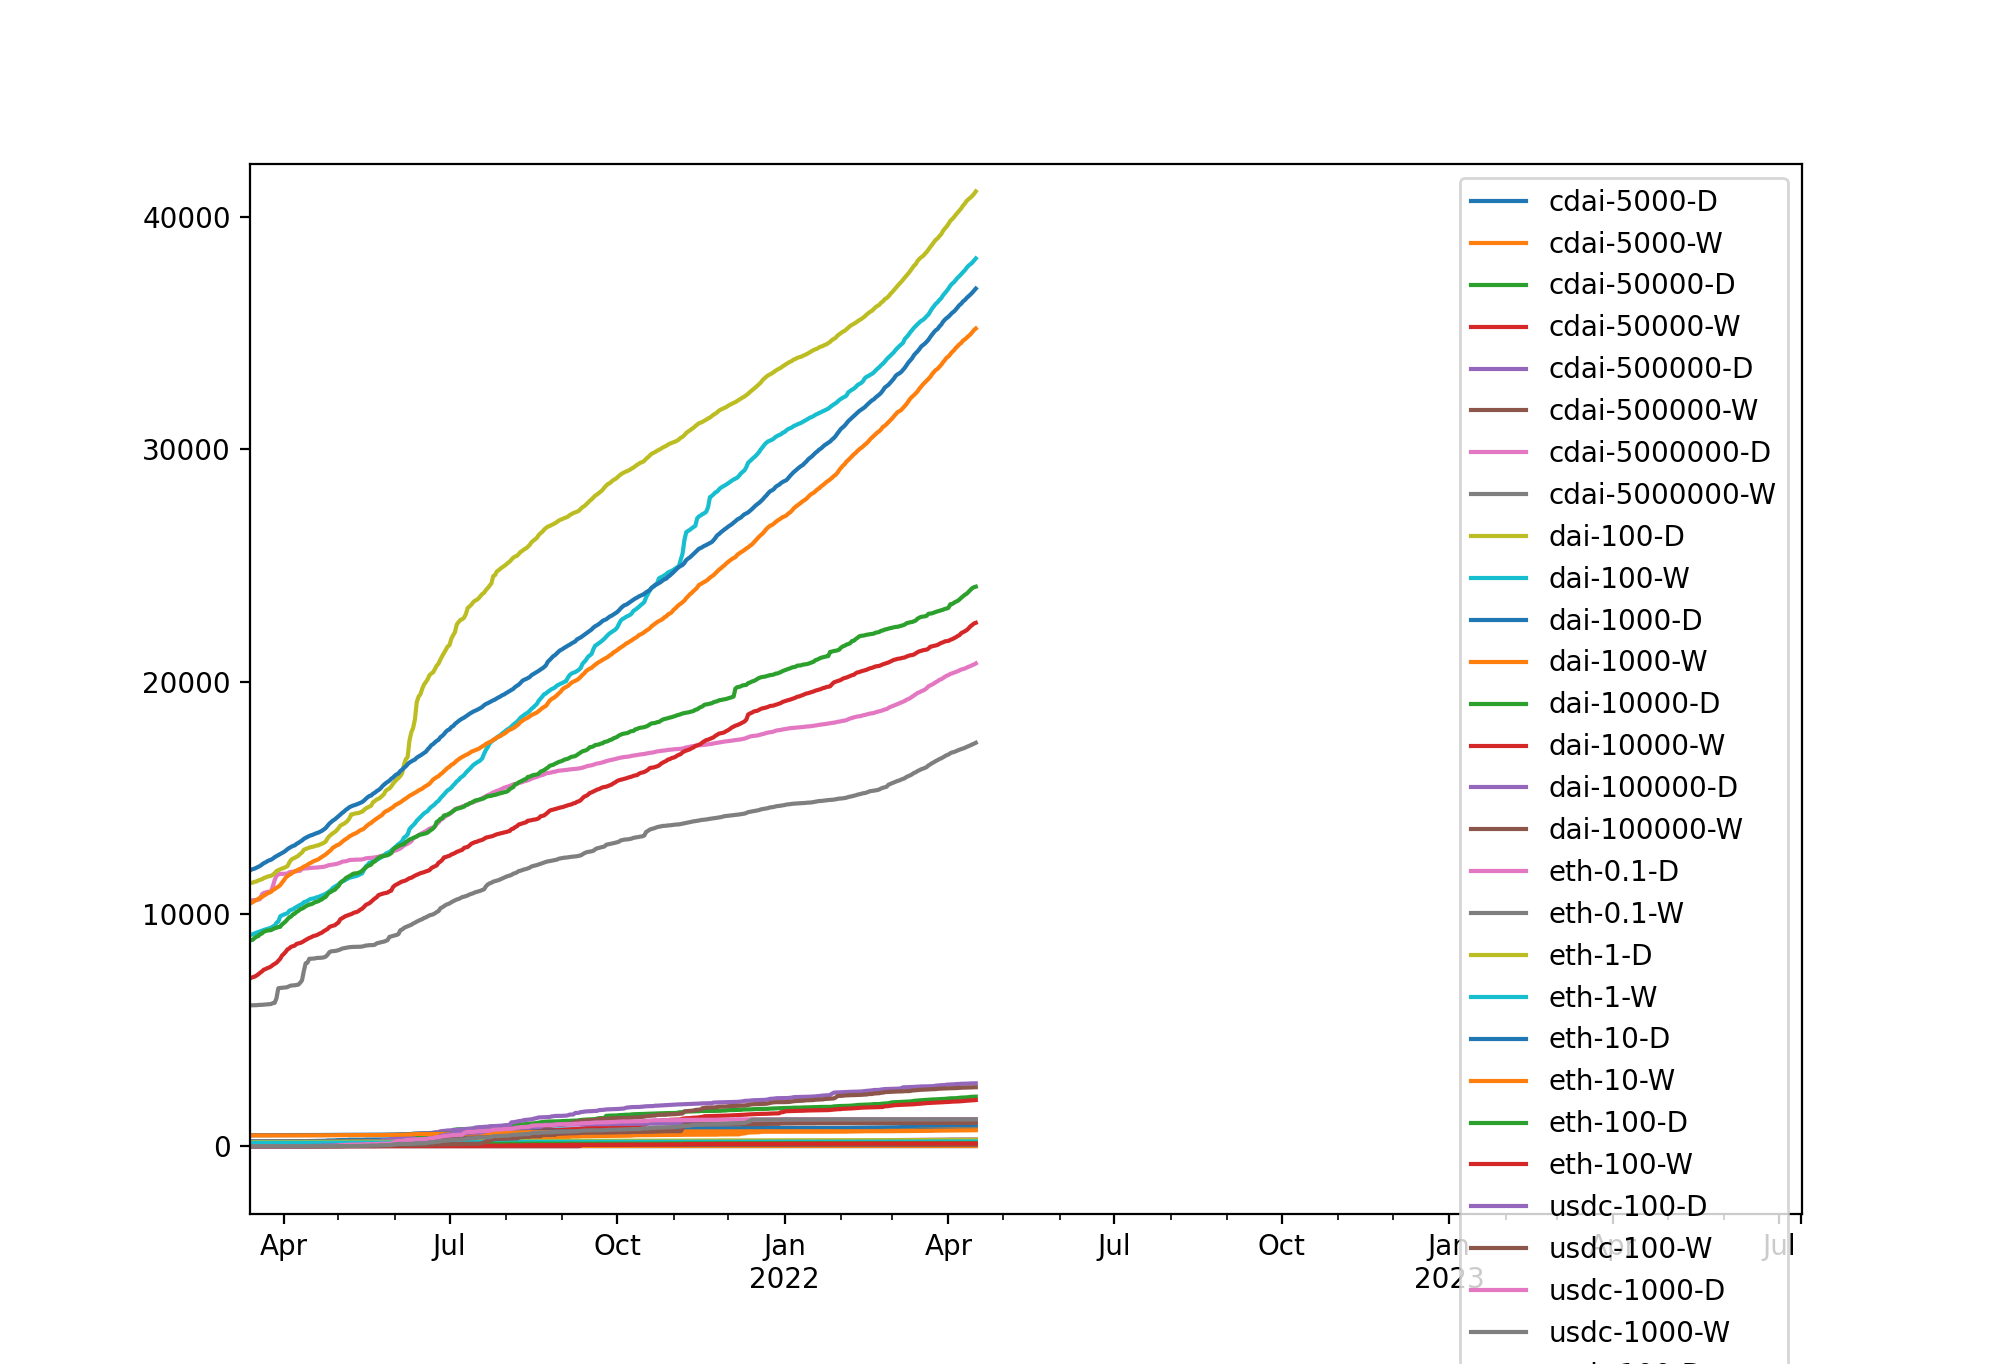

<AxesSubplot:>

In [5]:
%matplotlib notebook
eventDf.plot()

Level 1 (100$)

<IPython.core.display.Javascript object>


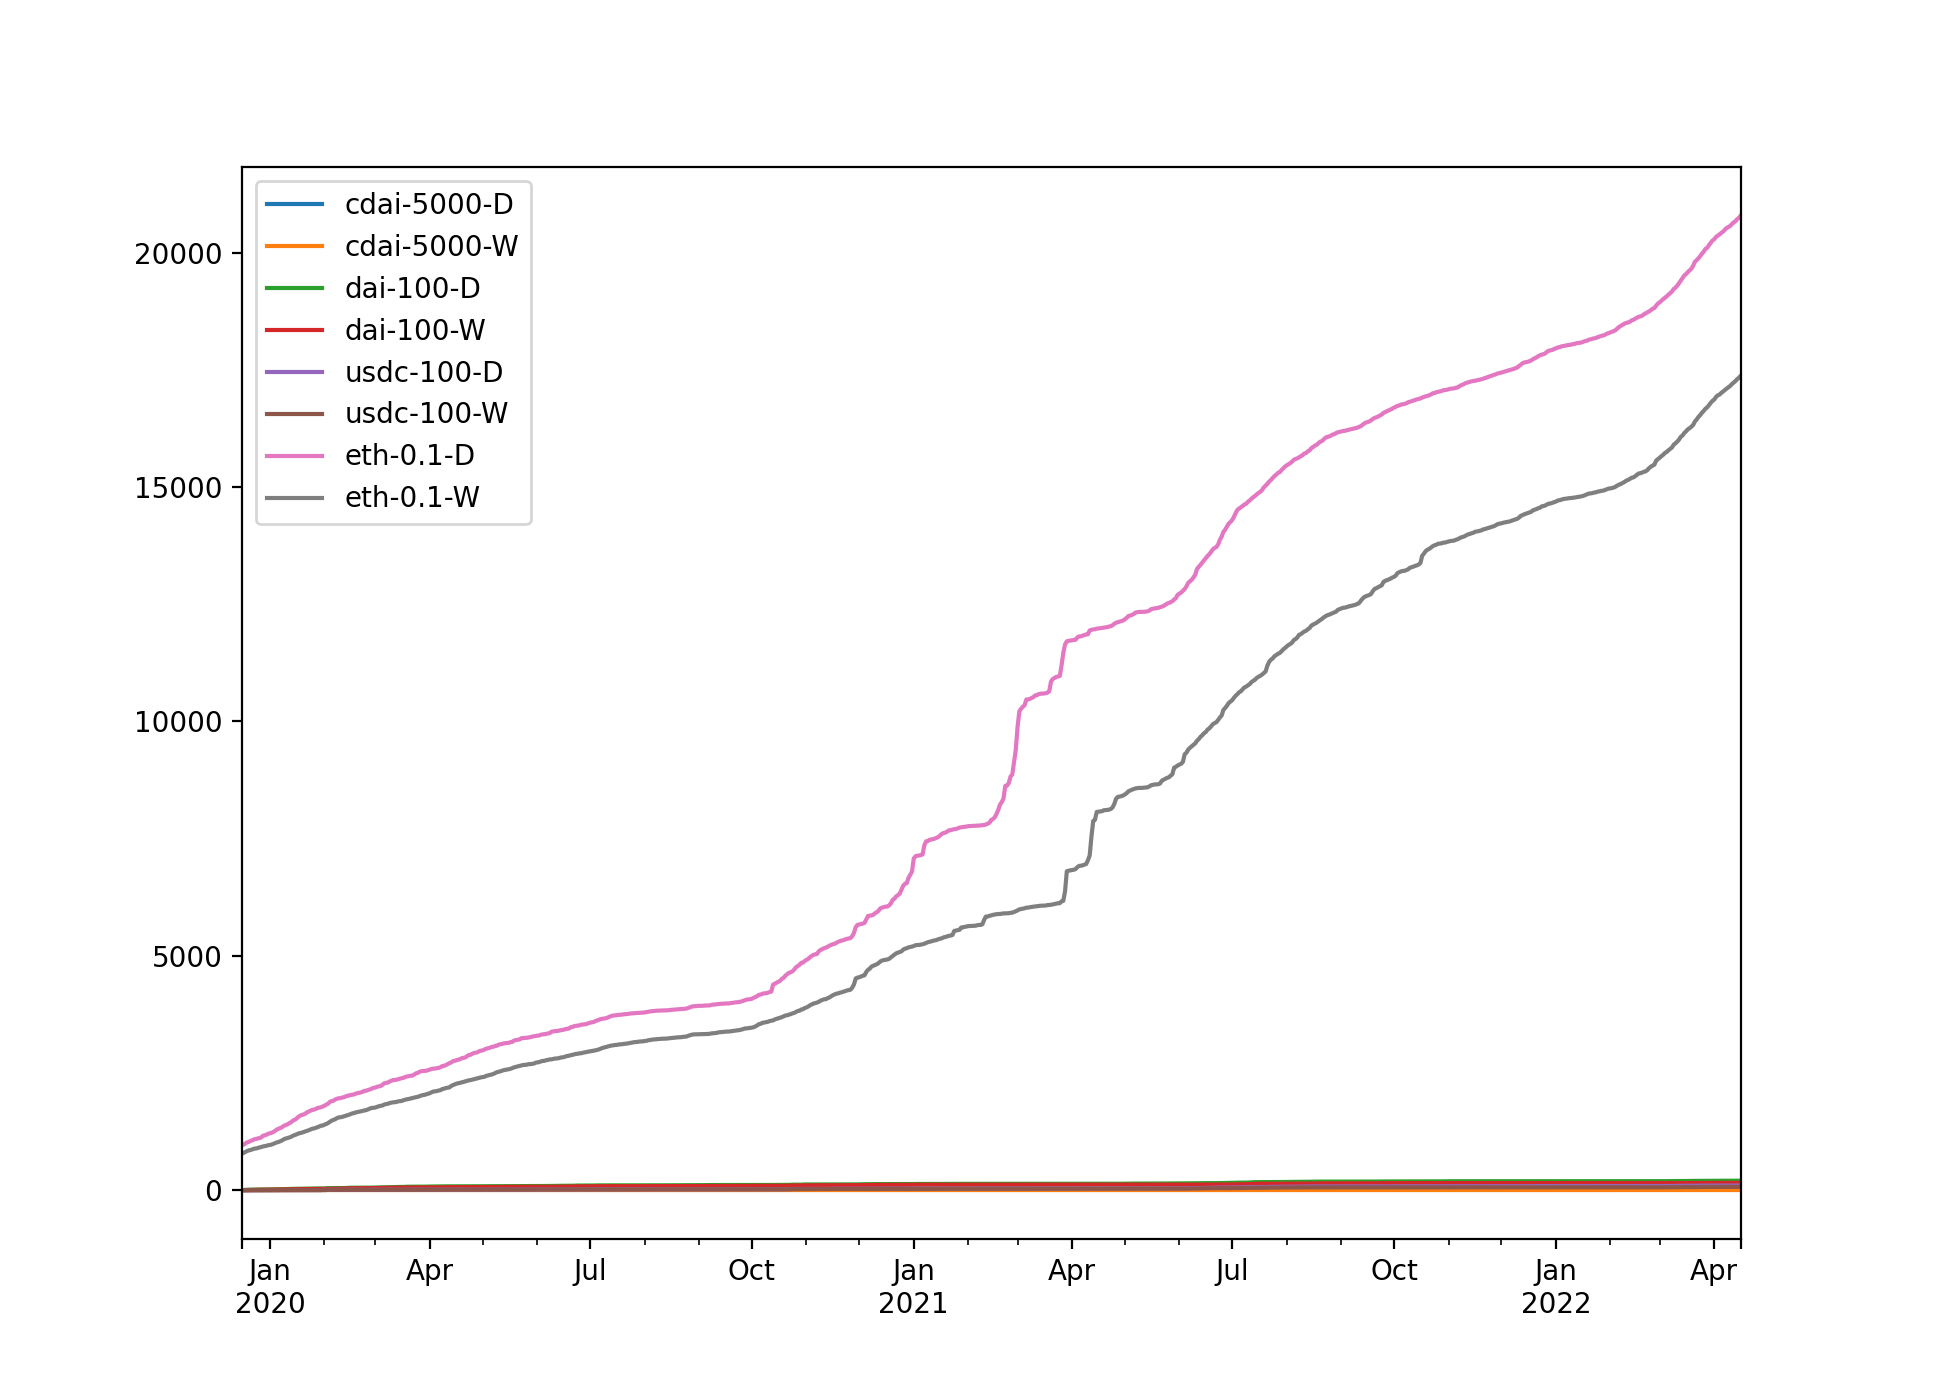

<AxesSubplot:>

In [7]:
%matplotlib notebook
eventDf[['cdai-5000-D','cdai-5000-W','dai-100-D','dai-100-W','usdc-100-D','usdc-100-W','eth-0.1-D','eth-0.1-W']].plot()

<IPython.core.display.Javascript object>


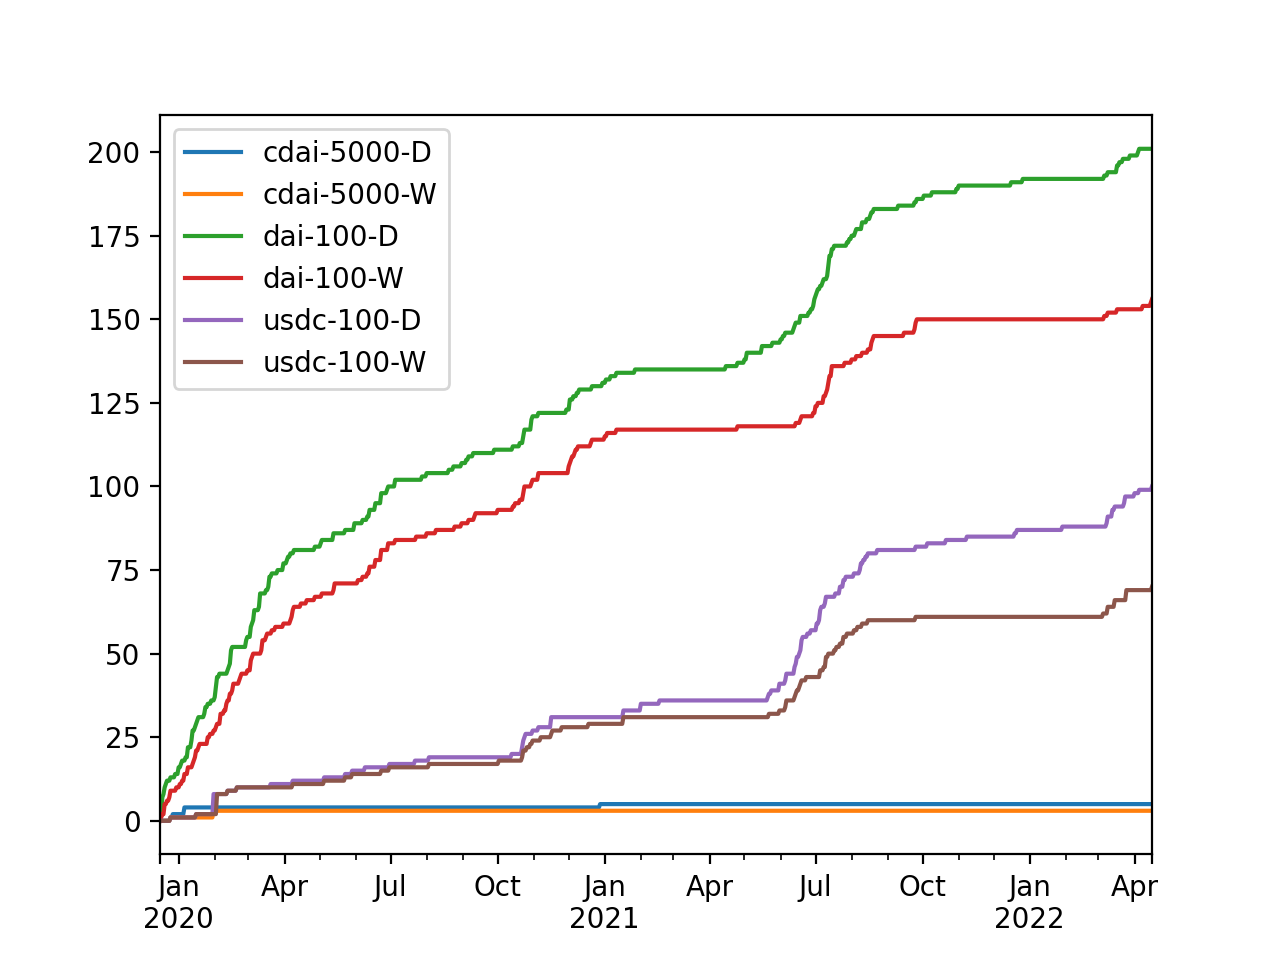

<AxesSubplot:>

In [8]:
eventDf[['cdai-5000-D','cdai-5000-W','dai-100-D','dai-100-W','usdc-100-D','usdc-100-W']].plot()

level 2(1000$)

<IPython.core.display.Javascript object>


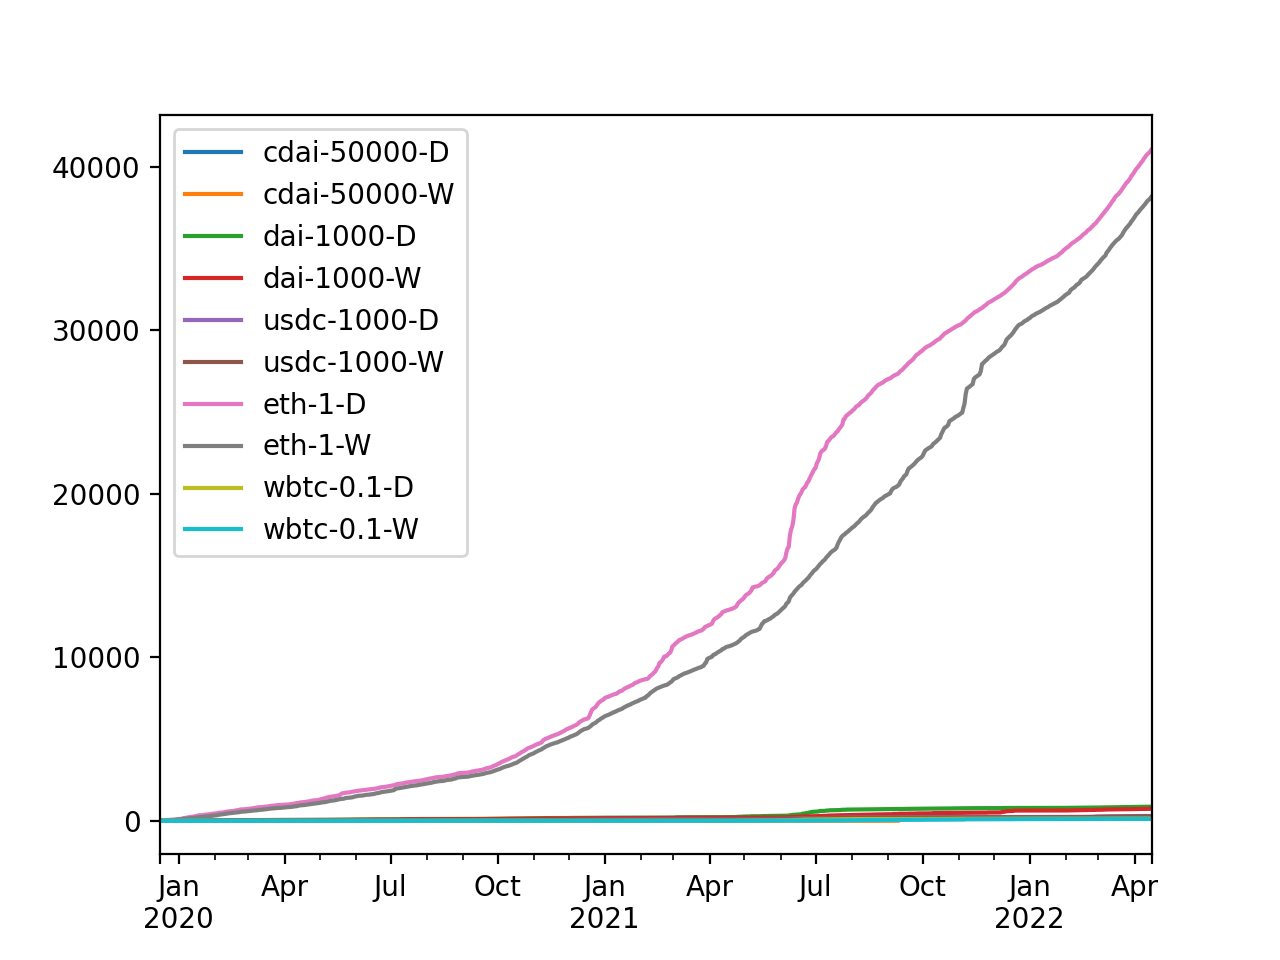

<AxesSubplot:>

In [14]:
eventDf[['cdai-50000-D','cdai-50000-W','dai-1000-D','dai-1000-W','usdc-1000-D','usdc-1000-W','eth-1-D','eth-1-W','wbtc-0.1-D','wbtc-0.1-W']].plot()

<IPython.core.display.Javascript object>


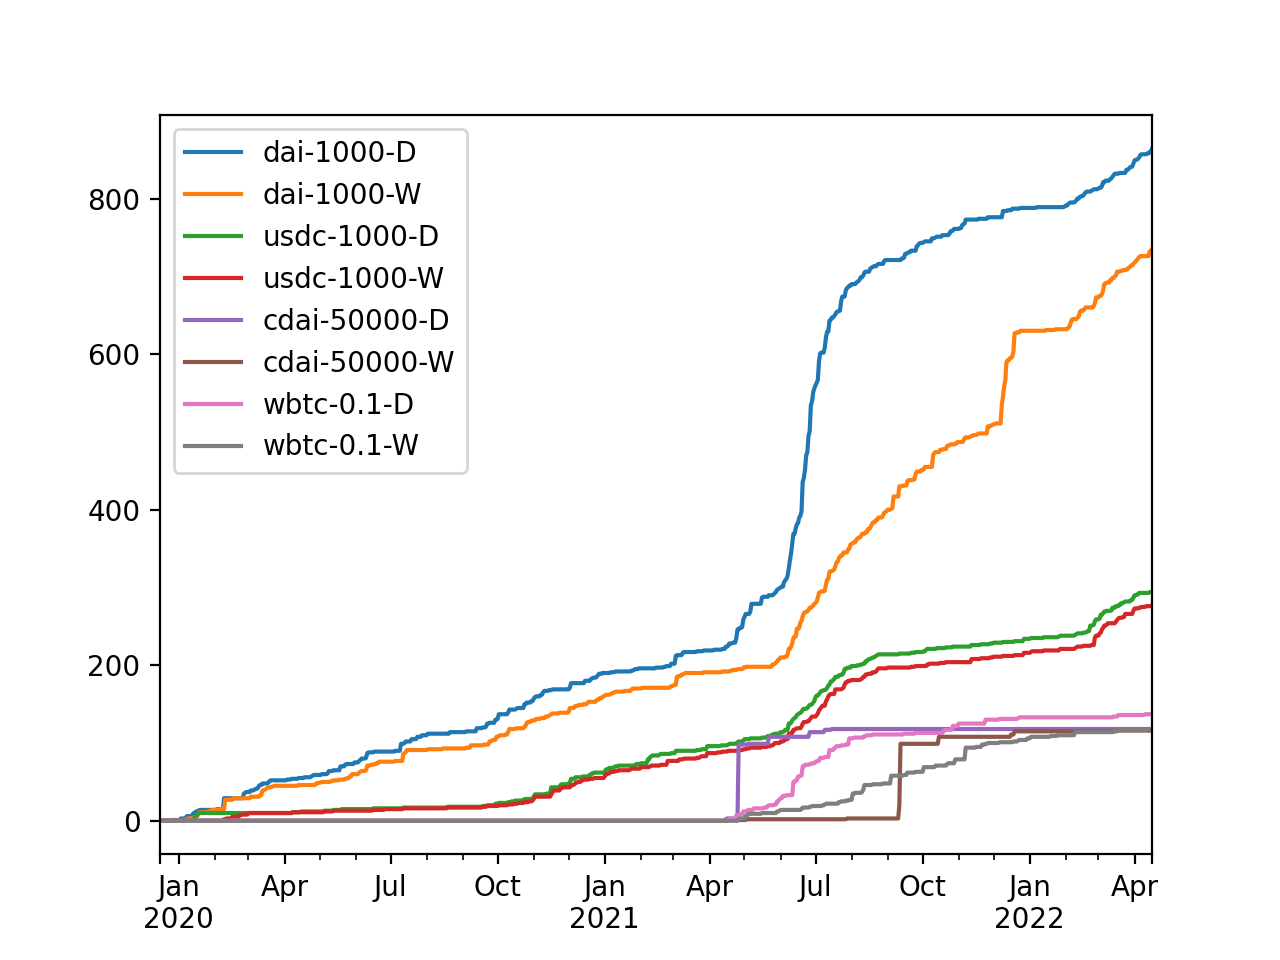

<AxesSubplot:>

In [17]:
eventDf[[
    'dai-1000-D',
    'dai-1000-W',
    'usdc-1000-D',
    'usdc-1000-W',
    'cdai-50000-D',
    'cdai-50000-W',
    'wbtc-0.1-D',
    'wbtc-0.1-W']].plot()

Level 10000$

<IPython.core.display.Javascript object>


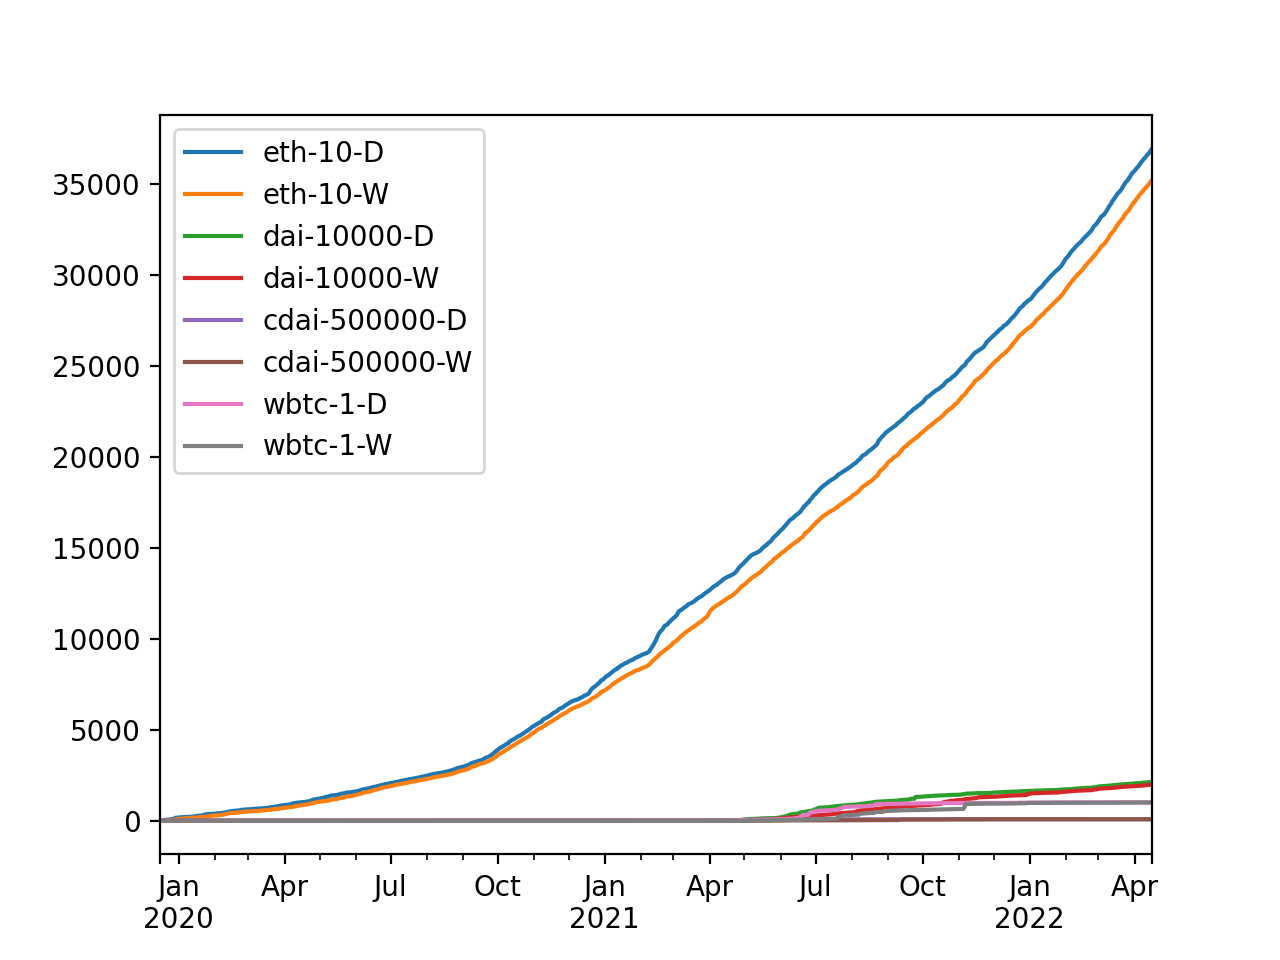

<AxesSubplot:>

In [22]:
eventDf[[
    'eth-10-D',
    'eth-10-W',
    'dai-10000-D',
    'dai-10000-W',
    'cdai-500000-D',
    'cdai-500000-W',
    'wbtc-1-D',
    'wbtc-1-W']].plot()

<IPython.core.display.Javascript object>


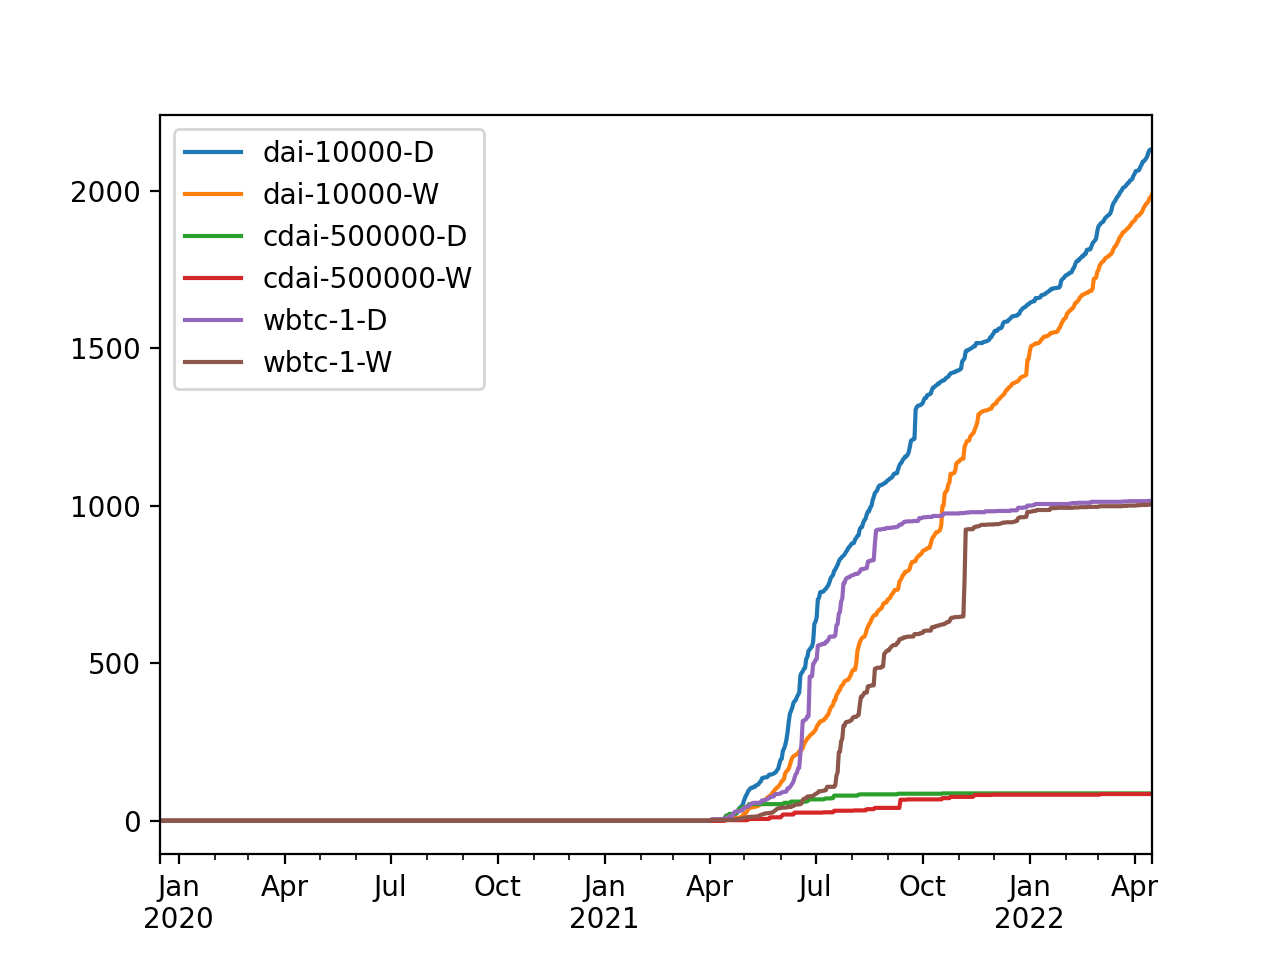

<AxesSubplot:>

In [24]:
eventDf[[
    'dai-10000-D',
    'dai-10000-W',
    'cdai-500000-D',
    'cdai-500000-W',
    'wbtc-1-D',
    'wbtc-1-W']].plot()

Level 100000$

<IPython.core.display.Javascript object>


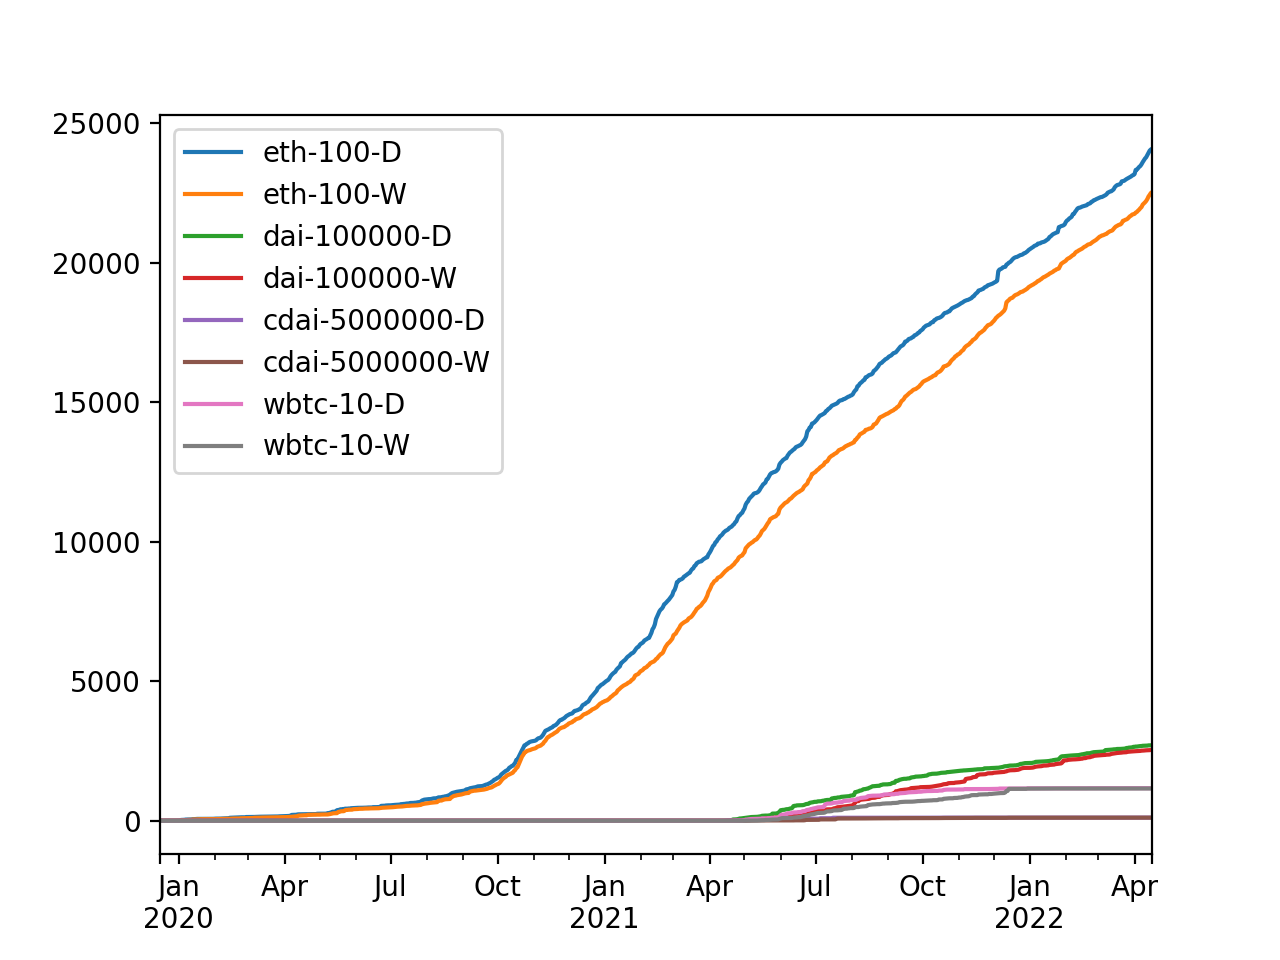

<AxesSubplot:>

In [26]:
eventDf[[
    'eth-100-D',
    'eth-100-W',
    'dai-100000-D',
    'dai-100000-W',
    'cdai-5000000-D',
    'cdai-5000000-W',
    'wbtc-10-D',
    'wbtc-10-W']].plot()

<IPython.core.display.Javascript object>


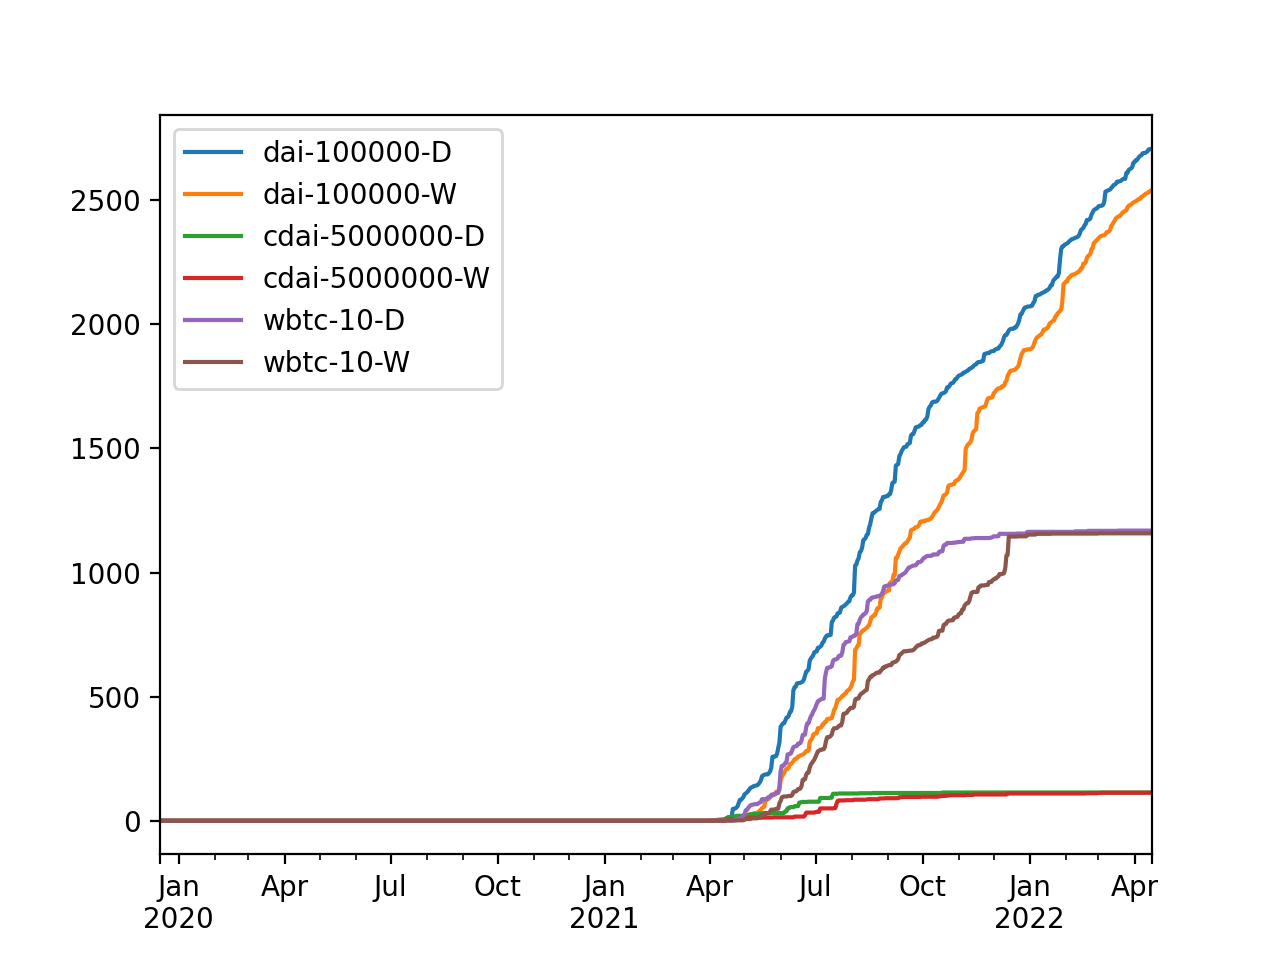

<AxesSubplot:>

In [27]:
eventDf[[
    'dai-100000-D',
    'dai-100000-W',
    'cdai-5000000-D',
    'cdai-5000000-W',
    'wbtc-10-D',
    'wbtc-10-W']].plot()